*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you need to create a machine learning model that will classify SMS messages as either "ham" or "spam". A "ham" message is a normal message sent by a friend. A "spam" message is an advertisement or a message sent by a company.

You should create a function called `predict_message` that takes a message string as an argument and returns a list. The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1). The second element in the list should be the word "ham" or "spam", depending on which is most likely.

For this challenge, you will use the [SMS Spam Collection dataset](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). The dataset has already been grouped into train data and test data.

The first two cells import the libraries and data. The final cell tests your model and function. Add your code in between these cells.


In [ ]:
# import libraries
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

In [2]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2022-03-28 09:32:56--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  --.-KB/s    in 0.1s    

2022-03-28 09:32:57 (2.62 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2022-03-28 09:32:57--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==============

In [3]:
# read files with pandas
df_train = pd.read_csv(train_file_path, sep='\t', header = None)
df_test = pd.read_csv(test_file_path, sep='\t', header = None)

In [4]:
# rename header
df_train.rename(columns={0:"Category", 1:"Message"}, inplace=True)
df_test.rename(columns={0:"Category", 1:"Message"}, inplace=True)

In [5]:
# convert Category to 0 and 1s
# Ham : 0, Spam : 1
df_train["Category"] = df_train["Category"].map({'ham': 0,'spam':1})
df_test["Category"] = df_test["Category"].map({'ham': 0,'spam':1})

In [6]:
df_train.head()

,Category,Message
0,0,ahhhh...just woken up!had a bad dream about u ...
1,0,you can never do nothing
2,0,"now u sound like manky scouse boy steve,like! ..."
3,0,mum say we wan to go then go... then she can s...
4,0,never y lei... i v lazy... got wat? dat day ü ...


In [7]:
df_test.head()

,Category,Message
0,0,i am in hospital da. . i will return home in e...
1,0,"not much, just some textin'. how bout you?"
2,0,i probably won't eat at all today. i think i'm...
3,0,don‘t give a flying monkeys wot they think and...
4,0,who are you seeing?


In [8]:
# amount of "Ham" and "Spam" quite imbalanced
print("Train set")
print(df_train["Category"].value_counts())
print("Test set")
print(df_test["Category"].value_counts())

Train set
0    3619
1     560
Name: Category, dtype: int64
Test set
0    1205
1     187
Name: Category, dtype: int64


In [9]:
# prepare the data
# convert to lists
training_sentences = df_train["Message"].tolist()
testing_sentences = df_test["Message"].tolist()
training_labels = df_train["Category"].tolist()
test_labels = df_test["Category"].tolist()
# convert labels to numpy arrays, to be used later
training_labels_final = np.array(training_labels)
test_labels_final = np.array(test_labels)

In [10]:
# import additional required libraries
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [11]:
# parameters used

# Tokenization params
vocab_size = 1000
# OOV = Out of vocabulary
# used to tokenize words that are not in the corpus
# to maintain sequence length
oov_tok = "<OOV>"

# Padding params
max_length = 100
# removes values from seq > max_length at the end
trunc_type='post'
# pad after each seq
padding_type='post'

# model param
embedding_dim = 16

In [12]:
# tokenization
# assign a unique number for each word in a sentence
# fit to training data 
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

In [13]:
print(word_index)

{'<OOV>': 1, 'i': 2, 'to': 3, 'you': 4, 'a': 5, 'the': 6, 'u': 7, 'and': 8, 'in': 9, 'is': 10, 'me': 11, 'my': 12, 'for': 13, 'your': 14, 'it': 15, 'of': 16, 'call': 17, 'have': 18, 'on': 19, 'now': 20, 'that': 21, '2': 22, 'are': 23, 'so': 24, 'but': 25, 'not': 26, 'or': 27, 'do': 28, 'at': 29, 'can': 30, "i'm": 31, 'will': 32, 'be': 33, 'with': 34, 'if': 35, 'get': 36, 'just': 37, 'ur': 38, 'no': 39, 'this': 40, 'we': 41, '4': 42, 'gt': 43, 'lt': 44, 'up': 45, 'ok': 46, 'go': 47, 'free': 48, 'when': 49, 'how': 50, 'out': 51, 'all': 52, 'from': 53, 'what': 54, 'know': 55, 'like': 56, 'then': 57, 'good': 58, 'got': 59, 'come': 60, 'its': 61, 'time': 62, 'day': 63, 'only': 64, 'am': 65, 'was': 66, 'he': 67, 'love': 68, 'send': 69, 'there': 70, 'as': 71, 'text': 72, 'txt': 73, 'want': 74, 'going': 75, 'one': 76, 'by': 77, 'ü': 78, 'about': 79, 'need': 80, 'still': 81, 'lor': 82, 'n': 83, 'r': 84, "i'll": 85, 'home': 86, 'our': 87, 'stop': 88, 'she': 89, 'see': 90, 'today': 91, 'sorry': 9

In [14]:
# sequencing
sequences = tokenizer.texts_to_sequences(training_sentences)

In [15]:
print(sequences)

[[1, 37, 1, 45, 143, 5, 402, 767, 79, 7, 726, 24, 2, 94, 56, 7, 163, 20, 2, 461, 55, 177, 79, 1, 111, 25, 2, 315, 154, 45, 13, 15], [4, 30, 282, 28, 341], [20, 7, 832, 56, 1, 1, 358, 1, 56, 2, 10, 1, 19, 96, 416, 86, 494, 114, 7, 1, 42, 1, 435, 538], [768, 145, 41, 277, 3, 47, 57, 47, 57, 89, 30, 1, 1, 342, 96, 1, 1], [282, 316, 607, 2, 262, 972, 59, 146, 317, 63, 78, 69, 11, 96, 1, 198, 141, 76], [9, 1, 1, 358, 516, 375, 100, 11, 6, 1, 1, 13, 435, 517, 2, 30, 376, 1, 19, 12, 973, 158, 302, 16, 1, 83, 1, 213, 1, 89, 160, 6, 1, 1, 1], [1, 539, 45, 50, 14, 540, 98, 69, 204, 148, 3, 12, 1], [108, 727, 417, 3, 1, 6, 1], [218, 17, 1, 53, 14, 403, 14, 891, 42, 1, 272, 27, 436, 518, 161, 577, 462, 578, 164, 318, 377, 329, 1, 1, 1, 974, 1, 273], [20, 21, 4, 18, 519, 94, 88, 37, 892, 13, 144, 58, 1, 8, 177, 2, 90, 21, 30, 258, 4, 330, 2, 385, 1, 4, 5, 975], [263, 769, 976, 541, 728, 20, 24, 73, 11, 49, 7, 291, 35, 7, 30, 68, 977, 359], [1, 167, 2, 243, 78, 57, 78, 729, 93, 24, 2, 195, 42, 78, 3

In [16]:
# padding
# ensure each sentence is of same length
padded = pad_sequences(sequences,maxlen=max_length, padding=padding_type, 
                       truncating=trunc_type)

In [17]:
print(padded)

[[  1  37   1 ...   0   0   0]
 [  4  30 282 ...   0   0   0]
 [ 20   7 832 ...   0   0   0]
 ...
 [ 48 465 338 ...   0   0   0]
 [ 98  88   1 ...   0   0   0]
 [100  12 402 ...   0   0   0]]


In [18]:
# do the same for validation or testing data
# sequencing and padding
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length, 
                               padding=padding_type, truncating=trunc_type)

In [19]:
print(testing_sequences)

[[2, 65, 9, 1, 96, 2, 32, 1, 86, 9, 532], [26, 116, 37, 120, 1, 50, 812, 4], [2, 382, 559, 366, 29, 52, 91, 2, 112, 31, 200, 1, 50, 66, 14, 421, 119, 7, 173, 11], [1, 151, 5, 1, 1, 494, 108, 112, 8, 2, 1, 1, 309, 110, 247, 16, 854, 8, 52, 21], [128, 23, 4, 866], [14, 1, 79, 11, 132, 245, 22, 1, 166, 1, 42, 896, 226, 1, 290, 1, 1, 305, 26, 1, 440, 1, 412, 725, 98, 93], [528, 61, 34, 11, 64, 20, 65, 75, 86], [134, 139, 52, 1, 508, 720], [5, 358, 66, 220, 22, 86, 204, 880, 1, 16, 1], [10, 38, 1, 22, 96, 1, 353, 167, 201, 157, 407, 1, 22, 96, 1, 1], [92, 79, 824, 1, 51, 1, 23, 4, 213, 3, 296, 158, 412, 27, 28, 4, 401, 18, 5, 170, 214], [31, 81, 487, 13, 5, 287, 3, 241, 8, 18, 26, 698, 1, 523, 603, 281], [98, 69, 11, 14, 595, 396], [119, 7, 59, 21, 1, 693], [2, 68, 3, 1, 2, 74, 3, 938, 4, 9, 12, 1, 1, 163, 20], [39, 472, 65, 866, 9, 568, 513, 24, 21, 2, 516], [122, 30, 4, 100, 11, 1, 595, 761, 450, 11, 3, 176, 138, 70, 25, 2, 59, 1, 8, 463, 26, 1, 204, 129], [314, 154, 163, 77, 314, 141], [

In [20]:
print(testing_padded)

[[  2  65   9 ...   0   0   0]
 [ 26 116  37 ...   0   0   0]
 [  2 382 559 ...   0   0   0]
 ...
 [125  23   4 ...   0   0   0]
 [ 38 161   1 ...   0   0   0]
 [ 26   1  53 ...   0   0   0]]


In [21]:
# make RNN model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           16000     
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 6)                 9606      
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 25,613
Trainable params: 25,613
Non-trainable params: 0
_________________________________________________________________


In [22]:
# train and test model
# model performance
history=model.fit(padded, training_labels_final, epochs=20, validation_data=(testing_padded, test_labels_final))

Epoch 1/20
131/131 [==============================] - 1s 4ms/step - loss: 0.2961 - accuracy: 0.8660 - val_loss: 0.1848 - val_accuracy: 0.8657
Epoch 2/20
131/131 [==============================] - 1s 5ms/step - loss: 0.1533 - accuracy: 0.9514 - val_loss: 0.1458 - val_accuracy: 0.9698
Epoch 3/20
131/131 [==============================] - 0s 3ms/step - loss: 0.1240 - accuracy: 0.9775 - val_loss: 0.1286 - val_accuracy: 0.9741
Epoch 4/20
131/131 [==============================] - 0s 3ms/step - loss: 0.1070 - accuracy: 0.9854 - val_loss: 0.1161 - val_accuracy: 0.9784
Epoch 5/20
131/131 [==============================] - 0s 3ms/step - loss: 0.0943 - accuracy: 0.9897 - val_loss: 0.1090 - val_accuracy: 0.9820
Epoch 6/20
131/131 [==============================] - 0s 3ms/step - loss: 0.0835 - accuracy: 0.9931 - val_loss: 0.1023 - val_accuracy: 0.9835
Epoch 7/20
131/131 [==============================] - 0s 3ms/step - loss: 0.0741 - accuracy: 0.9945 - val_loss: 0.0985 - val_accuracy: 0.9842
Epoch 

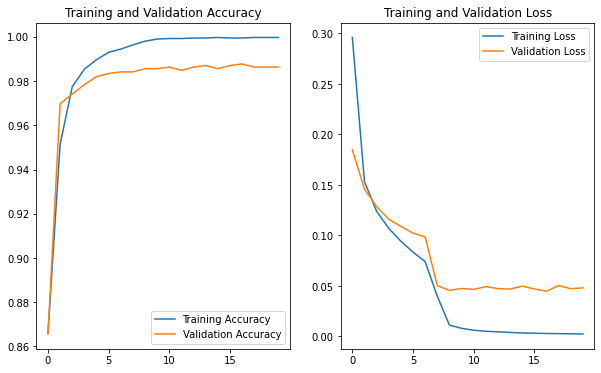

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
  text_list = []
  text_list.append(pred_text)
  sequences = tokenizer.texts_to_sequences(text_list)
  padded = pad_sequences(sequences,maxlen=max_length, 
                               padding=padding_type, truncating=trunc_type)
  prediction = []
  prob = model.predict(padded).item(0)
  prediction.append(prob)

  if prob <= 0.49:
    prediction.append("ham")
  else :
    prediction.append("spam")

  return (prediction)

pred_text = "wow, is your arm alright. that happened to me one time too"

prediction = predict_message(pred_text)
print(prediction)

1/1 [==============================] - 0s 89ms/step
[1.7578149709152058e-06, 'ham']


In [25]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 [==============================] - 0s 15ms/step
You passed the challenge. Great job!
